# [Noisy Deep Q-learning](https://arxiv.org/abs/1706.10295)

In [19]:
# #uncomment if you're running from colab
# %tensorflow_version 2.x

%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import deque,Counter
import random
import gym
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tqdm import tqdm_notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from solutions.memories import VanillaMemory
from solutions.networks import NoisyDenseNetwork, DenseNetwork
from solutions.agents import DQNAgent

# env = gym.make('MountainCar-v0')
env = gym.make('CartPole-v1')
mem = VanillaMemory(int(1e5)) 
a = DQNAgent(state_size = env.reset().shape[0], 
             action_size = env.action_space.n, replay_memory = mem,
             Architecture=NoisyDenseNetwork) 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [21]:
from datetime import datetime

scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
start_time = datetime.now()
solved_score=200
action_df = []
weight_df = []

for i in tqdm_notebook(range(10000)):
    if (i+1) % 100==0: print(f'Episdoe {i} Moving Average: {np.mean(scores_deque)}')
    state = env.reset()
    score = 0
    t=0
    actions = []
    while True:
        t+=1
        #select action
        action = a.act(state)  
        actions.append(action)

        #env step
        next_state, reward, done, info = env.step(action)   
        
        #engineer the reward to motivate your agent even more
        if done: 
            fake_reward = reward
        else:
            fake_reward = reward
        
        #agent step
        a.step(state,action,fake_reward,next_state,done)
        
        #collect score
        score += reward
        
        #go to next state
        state = next_state   
        
        #break if done
        if done: break
            
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))
    action_df.append(Counter(actions))
    weight_df.append([tf.reduce_mean(i).numpy() for i in a.network_local.get_weights()])

    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

Episdoe 99 Moving Average: 10.848484848484848
Episdoe 199 Moving Average: 9.37
Episdoe 299 Moving Average: 9.77
Episdoe 399 Moving Average: 13.43
Episdoe 499 Moving Average: 19.97
Episdoe 599 Moving Average: 22.21
Episdoe 699 Moving Average: 75.65
Solved at Play 756: 0:04:57.679806 Moving average: 200.19


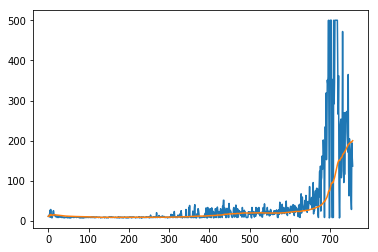

In [28]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.plot(moving_scores)

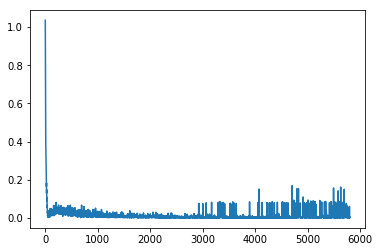

In [29]:
plt.plot(a.losses)

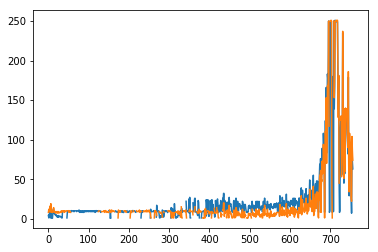

In [30]:
action_df = pd.DataFrame(action_df)
for i in action_df.columns:
    plt.plot(action_df[i])

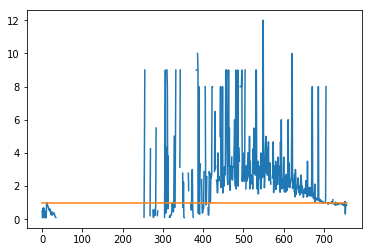

In [54]:
plt.plot(action_df[0]/action_df[1])
plt.plot([1 for i in range(action_df.shape[0])])

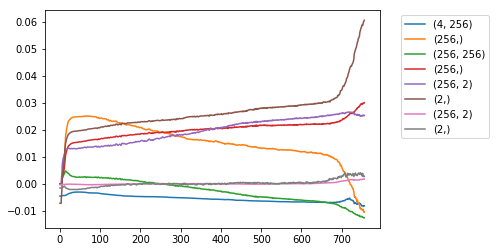

In [87]:
weight_df = pd.DataFrame(weight_df)
weight_df.columns = [str(i.shape) for i in a.network_local.get_weights()]
for i in range(weight_df.shape[1]):
    plt.plot(weight_df.iloc[:,i])
plt.legend(bbox_to_anchor=(1.05,1),loc=2)

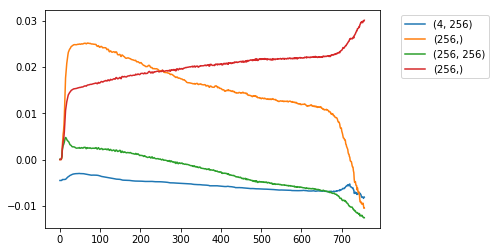

In [88]:
#Dense weights
for i in range(4):
    plt.plot(weight_df.iloc[:,i])
plt.legend(bbox_to_anchor=(1.05,1),loc=2)

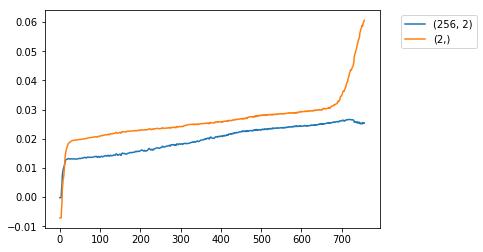

In [89]:
#Noisy weights; mean
for i in range(4,6):
    plt.plot(weight_df.iloc[:,i])
plt.legend(bbox_to_anchor=(1.05,1),loc=2)

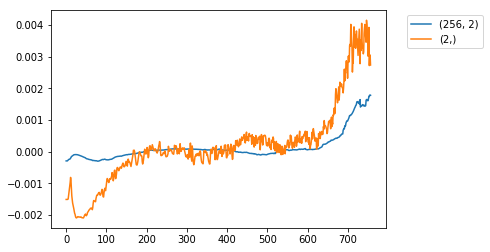

In [90]:
#Noisy weights; std
for i in range(6,8):
    plt.plot(weight_df.iloc[:,i])
plt.legend(bbox_to_anchor=(1.05,1),loc=2)

In [91]:
weight_df.head()

,"(4, 256)","(256,)","(256, 256)","(256,)","(256, 2)","(2,)","(256, 2)","(2,)"
0,-0.004518,0.000000,0.000052,0.000000,-0.000227,-0.007163,-0.000291,-0.001509
1,-0.004518,0.000000,0.000052,0.000000,-0.000227,-0.007163,-0.000291,-0.001509
2,-0.004518,0.000000,0.000052,0.000000,-0.000227,-0.007163,-0.000291,-0.001509
3,-0.004518,0.000000,0.000052,0.000000,-0.000227,-0.007163,-0.000291,-0.001509
4,-0.004517,0.000106,0.000257,0.000321,0.002375,-0.004169,-0.000276,-0.001504
